In [1]:
# import standard python modules
import sys
import os
import copy
import numpy as np
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid, make_axes_locatable
import lenstronomy
# import the lens model class 
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
# import the lens equation solver class (finding image plane positions of a source position)
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LensModel.Solver.solver4point import Solver4Point
from lenstronomy.LensModel.Solver.solver2point import Solver2Point
from lenstronomy.LensModel.Solver.solver import Solver
from astropy.io import fits
import lenstronomy.Util.util as util
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Plots import  plot_util
from lenstronomy.Plots import chain_plot
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.Sampling.parameters import Param
from lenstronomy.Util import mask_util
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Util.util import array2image
import lenstronomy.Util.param_util as param_util
import seaborn as sns

cwd = os.getcwd()
base_path = cwd
print('Base directory path:', base_path)

Base directory path: /Users/rodrigoc/Documents/AGEL/Duncan_examples/model_notebooks


### Importing data

In [2]:
def import_data(file_path):

    kwargs_data = {}
    
    data_file = os.path.join(base_path, '../'+file_path)
    f = fits.open(data_file)
    # storing data under correct keys
    kwargs_data.update({'image_data': f[0].data})
    f.close()

    # get PSF estimate from fits
    psf_file = os.path.join(base_path, '../mocks/PSF/mock_psf.fits')
    f = fits.open(psf_file)
    kernel_point_source = f[0].data
    f.close()

    # format psf kwargs
    kwargs_psf = {'psf_type': "PIXEL", 
                'kernel_point_source': kernel_point_source ,
                'kernel_point_source_init': kernel_point_source ,
                }

    return kwargs_data, kwargs_psf

kwargs_data_F200LP, kwargs_psf_F200LP = import_data('mocks/images/mock_1_image.fits')

### User defined parameters

In [3]:
# Lens and source redshifts
z_l = 0.5
z_s1 = 0.8
z_s2 = 1.7

# image multiplicity
s1_image_num = 4
s2_image_num = 2

# Data properties (use below values for mock images)
ra_at_xy_0 = -2.725
dec_at_xy_0 = -2.725
transform_pix2angle = np.array([[0.05, 0.  ],
                                [0.  , 0.05]])

### Setting up Coordinates() and PixelGrid() classes 

In [4]:
# set up the Coordinates class
coords_F200LP = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)

# read-in the reduced cutout image
image_data = kwargs_data_F200LP['image_data']
numPix = len(image_data)
deltaPix = coords_F200LP.pixel_width
print('Pixel size: {:.2f} arcsec'.format(deltaPix))
print('numPix:', numPix)
print()

kwargs_pixel = {'nx': numPix, 'ny': numPix,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle} 

pixel_grid = PixelGrid(**kwargs_pixel)

Pixel size: 0.05 arcsec
numPix: 110



### Cosmo model

In [5]:
from astropy.cosmology import FlatLambdaCDM, wCDM
import astropy.units as u

cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3, Ob0=0.05)

D_s1 = cosmo.angular_diameter_distance(z_s1).value
D_s2 = cosmo.angular_diameter_distance(z_s2).value
D_ls1 = cosmo.angular_diameter_distance_z1z2(z_l, z_s1).value
D_ls2 = cosmo.angular_diameter_distance_z1z2(z_l, z_s2).value

#cosmological scaling factor=deflection_scaling= 1/β
deflection_scaling = D_s1 / D_ls1 * D_ls2 / D_s2  
beta=1/deflection_scaling
print('Deflection angle rescale factor: {:.6f}'.format(deflection_scaling))
print('Beta:{:.6f}'.format(beta))

Deflection angle rescale factor: 1.858580
Beta:0.538045


### Show image and initial guesses of point source coordinates

/var/folders/5_/wvcj5nvd1hq5fwhbrwv87syw0000gn/T/ipykernel_1330/4103070107.py:3: RuntimeWarning: invalid value encountered in log10
  ax.matshow(np.log10(image_data), origin='lower', cmap='gray_r', vmin=-1.8, vmax=0.5)


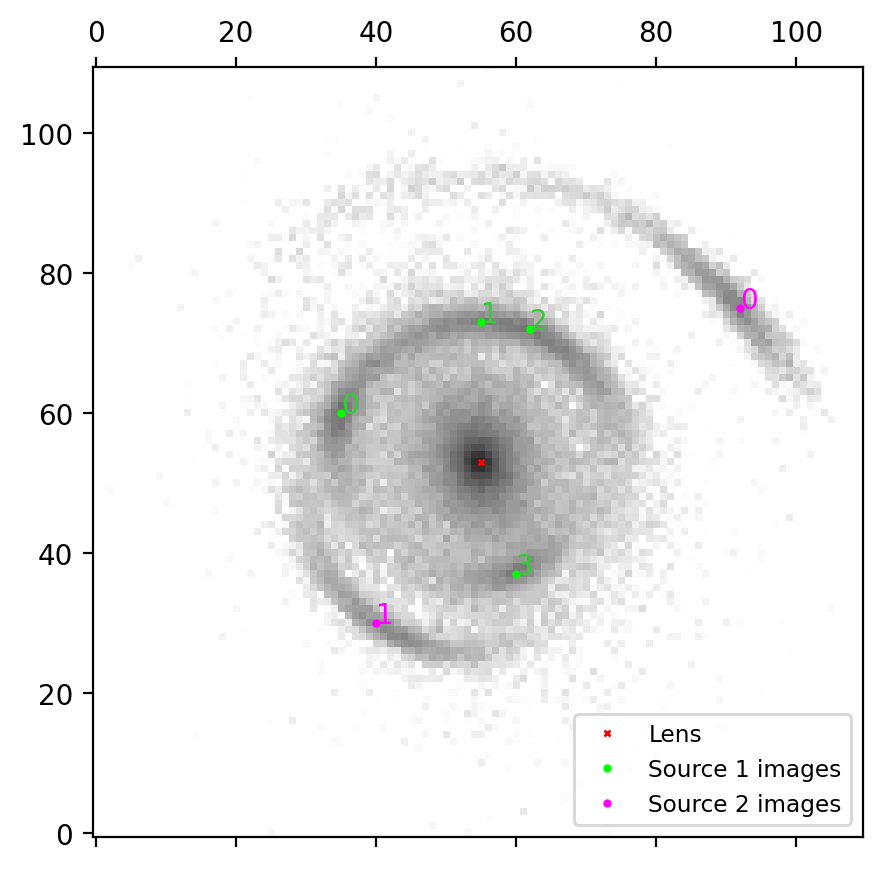

In [47]:
cmap = sns.cubehelix_palette(start=0.6, rot=-1.7, gamma=1, hue=1, light=-.7, dark=0.7, as_cmap=True)
ax = plt.figure(figsize=(5,5), dpi=200).gca()
ax.matshow(np.log10(image_data), origin='lower', cmap='gray_r', vmin=-1.8, vmax=0.5)

# plot_util.coordinate_arrows(ax, d=110, coords=pixel_grid, color='red', font_size=18, arrow_size=0.035)

# estimate lens position in pixel
lens_x_F200LP, lens_y_F200LP = 55, 53
lens_ra_F200LP, lens_dec_F200LP = coords_F200LP.map_pix2coord(lens_x_F200LP, lens_y_F200LP)
ax.plot(lens_x_F200LP, lens_y_F200LP, 'x', color='red', ms = 2, label='Lens') 

# estimate source 1 positions in pixel
s1_x_F200LP = np.array([35,55,62,60])
s1_y_F200LP = np.array([60,73,72,37])
ra_image_s1_F200LP, dec_image_s1_F200LP = coords_F200LP.map_pix2coord(s1_x_F200LP, s1_y_F200LP)
ax.plot(s1_x_F200LP, s1_y_F200LP, 'o', color='lime', ms = 2, label='Source 1 images')

# estimate source 2 positions in pixel
s2_x_F200LP = np.array([92,40])
s2_y_F200LP = np.array([75,30])
ra_image_s2_F200LP, dec_image_s2_F200LP = coords_F200LP.map_pix2coord(s2_x_F200LP, s2_y_F200LP)
ax.plot(s2_x_F200LP, s2_y_F200LP, 'o', color='magenta', ms = 2, label='Source 2 images')
 

for i in range(len(s1_x_F200LP)):
    ax.text(s1_x_F200LP[i], s1_y_F200LP[i], i, fontsize=10, color='limegreen')

for i in range(len(s2_x_F200LP)):
    ax.text(s2_x_F200LP[i], s2_y_F200LP[i], i, fontsize=10, color='magenta')

plt.legend(loc='lower right', fontsize='small')
plt.show()

### Position modeling of source 1

In [56]:
lens_model_list = ['SIE', 'SHEAR']  
kwargs_lens_init =[{'theta_E': 1.65,
   'e1': 0.0,
   'e2': 0.0,
   'center_x': lens_ra_F200LP,
   'center_y': lens_dec_F200LP}, 
  {'gamma1': 0.016, 
   'gamma2': 0.0, 
   'ra_0': 0, 
   'dec_0': 0}]

# initialisation of the lens model class and the lens equation solver
lensModel_s1 = LensModel(lens_model_list=lens_model_list)

if s1_image_num==4:
   # 4 image solver
   solver4Point_s1 = Solver4Point(lensModel=lensModel_s1, solver_type='PROFILE_SHEAR')
   # new lens model params based on source image pos
   kwargs_fit_s1, precision = solver4Point_s1.constraint_lensmodel(x_pos=ra_image_s1_F200LP, y_pos=dec_image_s1_F200LP, kwargs_list=kwargs_lens_init, xtol=1.49012e-12)

else:
   # 2 image solver
   solver2Point_s1 = Solver2Point(lensModel=lensModel_s1, solver_type='THETA_E_PHI')
   # new lens model params based on source image pos
   kwargs_fit_s1, precision = solver2Point_s1.constraint_lensmodel(x_pos=ra_image_s1_F200LP, y_pos=dec_image_s1_F200LP, kwargs_list=kwargs_lens_init, xtol=1.49012e-12)

print("\n the fitted model parameters are: ", kwargs_fit_s1)

# estimating source plane position based on lens model and each image
s1_x_list, s1_y_list = lensModel_s1.ray_shooting(ra_image_s1_F200LP, dec_image_s1_F200LP, kwargs_fit_s1)
print("\n The relative x position in the source plane (should match) is: ", s1_x_list)
print("\n The relative y position in the source plane (should match) is: ", s1_y_list)

# we can now set a new estimate of the source position
s1_x = np.mean(s1_x_list)
s1_y = np.mean(s1_y_list)
print("\n mean source pos",s1_x,s1_y)


 the fitted model parameters are:  [{'theta_E': 0.9815586265151521, 'e1': -0.14668952838843874, 'e2': -0.06318506890453092, 'center_x': 0.02980236216952022, 'center_y': -0.14109397289464545}, {'gamma1': -0.006073458806273125, 'gamma2': 0.014802469325369442, 'ra_0': 0, 'dec_0': 0}]

 The relative x position in the source plane (should match) is:  [-0.02972154 -0.02873208 -0.03154803 -0.02878795]

 The relative y position in the source plane (should match) is:  [-0.00692654 -0.00748282 -0.00530355 -0.00651988]

 mean source pos -0.029697399726955696 -0.006558196014230522


### Verifying model and predicted source position reproduce images

In [49]:
lensEquationSolver_new = LensEquationSolver(lensModel=lensModel_s1) #gives img positions given lens model and source
ra_image_s1_pred, dec_image_s1_pred = lensEquationSolver_new.image_position_from_source(kwargs_lens=kwargs_fit_s1, sourcePos_x=s1_x, sourcePos_y=s1_y, min_distance=0.05, search_window=10, precision_limit=10**(-12), num_iter_max=100, verbose=True)
print("\n predicted imag pos based on lens init para",ra_image_s1_pred, dec_image_s1_pred) 

There are 9 regions identified that could contain a solution of the lens equation withcoordinates [ 0.275 -0.975 -0.925 -0.525 -0.425  0.475 -0.275  0.375  0.025] and [-0.875  0.275  0.375  0.775  0.825  0.825  0.875  0.875  0.925] 
The number of regions that meet the plausibility criteria are 9
Solution found for region 0 with required precision at iteration 3
Solution found for region 1 with required precision at iteration 3
Solution found for region 2 with required precision at iteration 5
Solution found for region 3 with required precision at iteration 15
Solution found for region 4 with required precision at iteration 13
Solution found for region 5 with required precision at iteration 5
Solution found for region 6 with required precision at iteration 9
Solution found for region 7 with required precision at iteration 4
Solution found for region 8 with required precision at iteration 3

 predicted imag pos based on lens init para [-0.97384854  0.41449455  0.03640176  0.27732148] [ 0

### Showing predicted positions

/var/folders/5_/wvcj5nvd1hq5fwhbrwv87syw0000gn/T/ipykernel_1330/2528314133.py:3: RuntimeWarning: invalid value encountered in log10
  ax.matshow(np.log10(image_data), origin='lower', cmap='gray_r', vmin=-1.9, vmax=0.5)


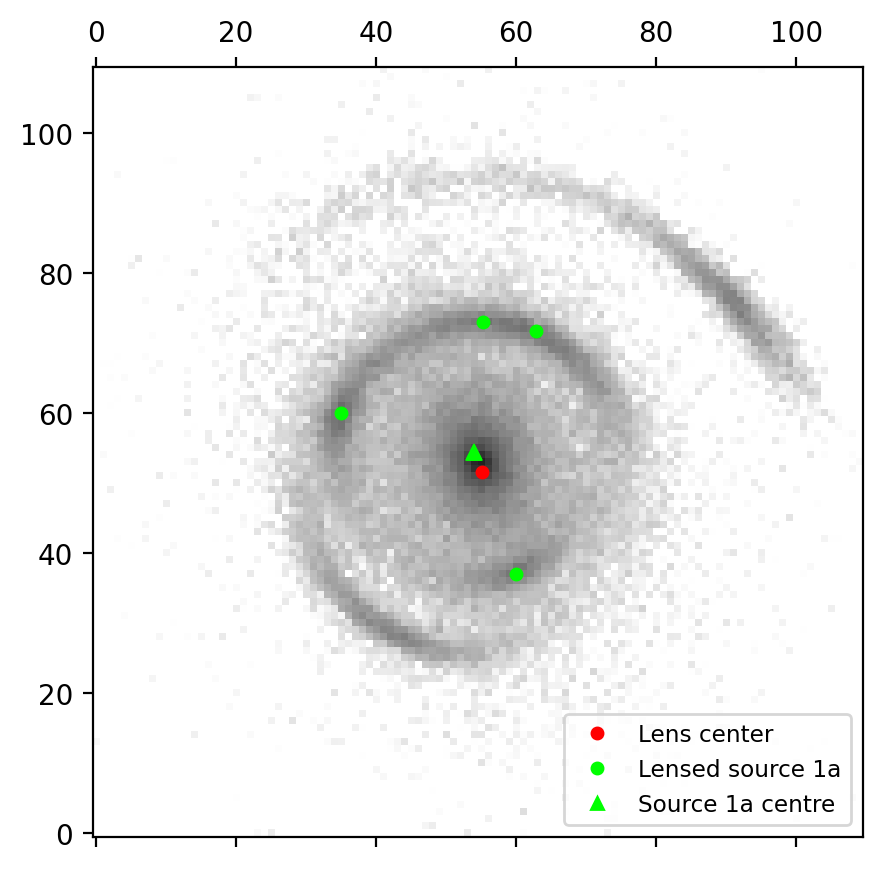

In [50]:
cmap = sns.cubehelix_palette(start=0.6, rot=-1.7, gamma=1, hue=1, light=-.7, dark=0.7, as_cmap=True)
ax = plt.figure(figsize=(5,5), dpi=200).gca()
ax.matshow(np.log10(image_data), origin='lower', cmap='gray_r', vmin=-1.9, vmax=0.5)

pred_lens_x, pred_lens_y = coords_F200LP.map_coord2pix(kwargs_fit_s1[0]['center_x'], kwargs_fit_s1[0]['center_y'])
ax.plot(pred_lens_x, pred_lens_y, 'o', color='red', ms = 4, label='Lens center') 

s1_x_F200LP, s1_y_F200LP = coords_F200LP.map_coord2pix(ra_image_s1_pred, dec_image_s1_pred)
ax.plot(s1_x_F200LP, s1_y_F200LP, 'o', color='lime', ms = 4, label='Lensed source 1a')

mean_beta_x, mean_beta_y = coords_F200LP.map_coord2pix(s1_x_list, s1_y_list)
ax.plot(mean_beta_x, mean_beta_y, '^', color='lime', ms = 4, label='Source 1a centre')

plt.legend(loc='lower right', fontsize='small')
plt.show()

### Lens model convergence

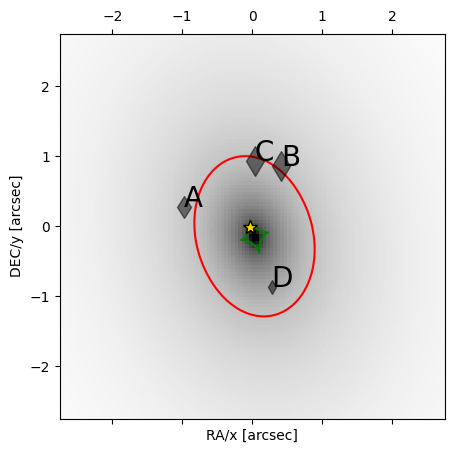

In [51]:
from lenstronomy.Plots import lens_plot
f, ax = plt.subplots(1, 1, figsize=(5, 5), sharex=False, sharey=False)
lens_plot.lens_model_plot(ax, lensModel=lensModel_s1, kwargs_lens=kwargs_fit_s1, numPix=110,deltaPix=0.05, sourcePos_x=s1_x, sourcePos_y=s1_y, point_source=True, with_caustics=True, fast_caustic=True, coord_inverse=False)
plt.show()

### Multi-plane mode position modeling for s1 & s2

In [52]:
lens_model_list_mp = ['EPL','SHEAR','SIE'] 

# specify redshifts of deflectors
redshift_list = [z_l, z_l, z_s1]  

# specify source redshift 
z_source = z_s2

kwargs_mass_s1 = {'theta_E': 0.0,
   'e1': 0.0,
   'e2': 0.0,
   'center_x': s1_x,
   'center_y': s1_y}
 
kwargs_lens_init = kwargs_fit_s1   
kwargs_lens_init.append(kwargs_mass_s1)

# initialisation of the lens model class and the lens equation solver
lensModel_mp = LensModel(lens_model_list=lens_model_list_mp, z_source=z_source, lens_redshift_list=redshift_list, cosmo= cosmo, multi_plane=True) #lens_model_list_simple[:2] for slicing

if s2_image_num==4:
   # 4 image solver
   solver4Point_mp = Solver4Point(lensModel=lensModel_mp, solver_type='PROFILE_SHEAR')
   # new lens model params based on source image pos
   kwargs_fit_mp, precision = solver4Point_mp.constraint_lensmodel(x_pos=ra_image_s2_F200LP, y_pos=dec_image_s2_F200LP, kwargs_list=kwargs_lens_init, xtol=1.49012e-12)

else:
   # 2 image solver
   solver2Point_mp = Solver2Point(lensModel=lensModel_mp, solver_type='THETA_E_PHI')
   # new lens model params based on source image pos
   kwargs_fit_mp, precision = solver2Point_mp.constraint_lensmodel(x_pos=ra_image_s2_F200LP, y_pos=dec_image_s2_F200LP, kwargs_list=kwargs_lens_init, xtol=1.49012e-12)

print("\n the re-fitted macro-model parameters are: ", kwargs_fit_mp)

kwargs_fit_init_use_last_best_mp= kwargs_fit_mp

s2_x_list, s2_y_list = lensModel_mp.ray_shooting(ra_image_s2_F200LP, dec_image_s2_F200LP, kwargs_fit_mp)
print(s2_x_list)
print(s2_y_list)
print("\n The relative x position in the source plane (should match) is: ", s2_x_list)
print("\n The relative y position in the source plane (should match) is: ", s2_y_list)

# we can now set a new estimate of the source position
s2_x = np.mean(s2_x_list)
s2_y = np.mean(s2_y_list)
print("\n new mean source pos",s2_x,s2_y)



 the re-fitted macro-model parameters are:  [{'theta_E': 1.7104341538567531, 'gamma': 2.0, 'e1': -0.14998873081438147, 'e2': -0.0658381096436249, 'center_x': 0.031900265845358516, 'center_y': -0.14556935914780422}, {'gamma1': -0.01573156220201001, 'gamma2': 0.0029185528407567165, 'ra_0': 0, 'dec_0': 0}, {'theta_E': 0.0, 'e1': 0.0, 'e2': 0.0, 'center_x': -0.029117910235873692, 'center_y': -0.006857098975273035}]
[0.3474666  0.39777899]
[0.15151156 0.08866546]

 The relative x position in the source plane (should match) is:  [0.3474666  0.39777899]

 The relative y position in the source plane (should match) is:  [0.15151156 0.08866546]

 new mean source pos 0.372622796607731 0.12008851104310789


/Users/rodrigoc/opt/anaconda3/envs/lens_tutorial_duncan/lib/python3.13/site-packages/lenstronomy/LensModel/lens_model.py:96: UserWarning: Astropy Cosmology is provided. Make sure your cosmology model is consistent with the cosmology_model argument.
  warnings.warn(
/Users/rodrigoc/opt/anaconda3/envs/lens_tutorial_duncan/lib/python3.13/site-packages/lenstronomy/LensModel/MultiPlane/multi_plane.py:76: UserWarning: Cosmology is provided. Make sure your cosmological model is consistent with the cosmology_model argument.
  warnings.warn(
/Users/rodrigoc/opt/anaconda3/envs/lens_tutorial_duncan/lib/python3.13/site-packages/lenstronomy/LensModel/Solver/solver2point.py:88: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  x = scipy.optimize.fsolve(


In [53]:
lensEquationSolver_new = LensEquationSolver(lensModel=lensModel_mp) #gives img positions given lens model and source
ra_image_s2_pred, dec_image_s2_pred = lensEquationSolver_new.image_position_from_source(kwargs_lens=kwargs_fit_mp, sourcePos_x=s2_x, sourcePos_y=s2_y, min_distance=0.04, search_window=100, precision_limit=10**(-10), num_iter_max=500)
print("\n predicted imag pos based on lens init para",ra_image_s2_pred, dec_image_s2_pred) 



 predicted imag pos based on lens init para [ 1.94293756 -0.59809571] [ 0.91788907 -1.29029672]


/var/folders/5_/wvcj5nvd1hq5fwhbrwv87syw0000gn/T/ipykernel_1330/816606451.py:3: RuntimeWarning: invalid value encountered in log10
  ax.matshow(np.log10(image_data), origin='lower', cmap='gray_r', vmin=-1.9, vmax=0.5)


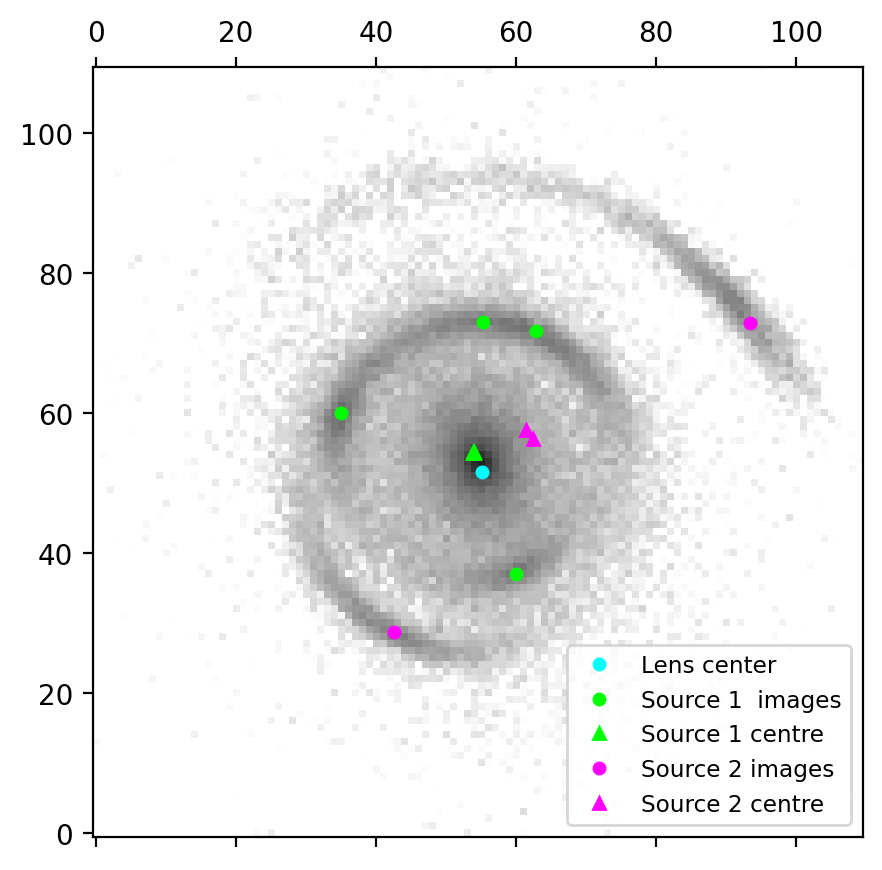

In [54]:
cmap = sns.cubehelix_palette(start=0.6, rot=-1.7, gamma=1, hue=1, light=-.7, dark=0.7, as_cmap=True)
ax = plt.figure(figsize=(5,5), dpi=200).gca()
ax.matshow(np.log10(image_data), origin='lower', cmap='gray_r', vmin=-1.9, vmax=0.5)

pred_lens_x, pred_lens_y = coords_F200LP.map_coord2pix(kwargs_fit_s1[0]['center_x'], kwargs_fit_s1[0]['center_y'])
ax.plot(pred_lens_x, pred_lens_y, 'o', color='cyan', ms = 4, label='Lens center') 

s1_x_F200LP, s1_y_F200LP = coords_F200LP.map_coord2pix(ra_image_s1_pred, dec_image_s1_pred)
ax.plot(s1_x_F200LP, s1_y_F200LP, 'o', color='lime', ms = 4, label='Source 1  images')

mean_beta_x, mean_beta_y = coords_F200LP.map_coord2pix(s1_x_list, s1_y_list)
ax.plot(mean_beta_x, mean_beta_y, '^', color='lime', ms = 4, label='Source 1 centre')

s2_x_F200LP, s2_y_F200LP = coords_F200LP.map_coord2pix(ra_image_s2_pred, dec_image_s2_pred)
ax.plot(s2_x_F200LP, s2_y_F200LP, 'o', color='magenta', ms = 4, label='Source 2 images')

mean_beta_x_s2, mean_beta_y_s2 = coords_F200LP.map_coord2pix(s2_x_list, s2_y_list)
ax.plot(mean_beta_x_s2, mean_beta_y_s2, '^', color='magenta', ms = 4, label='Source 2 centre')

plt.legend(loc='lower right', fontsize='small')
plt.show()

### Lens model convergence

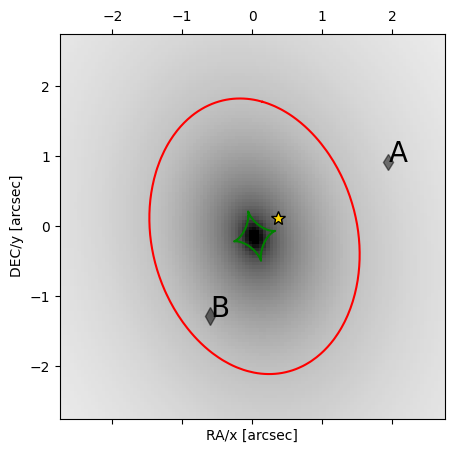

In [55]:
f, ax = plt.subplots(1, 1, figsize=(5, 5), sharex=False, sharey=False)
lens_plot.lens_model_plot(ax, lensModel=lensModel_mp, kwargs_lens=kwargs_fit_mp, numPix=110,deltaPix=0.05, sourcePos_x=s2_x, sourcePos_y=s2_y, point_source=True, with_caustics=True, fast_caustic=True, coord_inverse=False)
plt.show()